Required Packages 

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lime
import lime.lime_tabular

import botorch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.multi_objective.analytic import ExpectedHypervolumeImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning


from utilsv2 import *

 Setting Random State , Data Type, and Devices

In [2]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

Renaming the Column

In [3]:
transposed_data=transpose_dataset('./final_dataset_pre_processed.csv')

column_mapping = {
    'Cathode Electrode Thickness': 'CE_thickness',
    'Loading Level': 'Loading_level',
    'Anode lithium Thickness': 'AE_thickness',
    'Anode lCurrent collector Thickness': 'ACC_thickness',
    'Separator Polymer Thickness': 'Sep_pol_thickness',
    'Separator Ceramic Thickness': 'Sep_cer_thickness',
    '1st Charge Capacity': 'first_char_capacity',
    '1st Discharge Capacity': 'first_dischar_capacity',
    'AC-IR6 (mΩ)': 'IR6',
}

df_renamed=rename_columns(transposed_data,column_mapping)

Processing Data

In [4]:
data=df_renamed[['CE_thickness', 'Loading_level',
    'AE_thickness', 'ACC_thickness',
    'Sep_pol_thickness', 'Sep_cer_thickness','first_dischar_capacity']]
data=data.apply(pd.to_numeric)
data.fillna(data.mean(), inplace=True)

X=data[['CE_thickness', 'Loading_level',
    'AE_thickness', 'ACC_thickness',
    'Sep_pol_thickness', 'Sep_cer_thickness']]
y=data[['first_dischar_capacity']]

In [5]:
X

CE_thickness  Loading_level  AE_thickness  ACC_thickness  \
0            99.0          27.78          40.0            6.0   
1            99.0          27.78          40.0            6.0   
2            99.0          27.78          40.0            6.0   
3            99.0          27.78          40.0            6.0   
4            99.0          27.78          40.0            6.0   
..            ...            ...           ...            ...   
118         100.7          27.58          42.0            7.0   
119         100.7          27.58          42.0            7.0   
120         100.7          27.58          41.0            6.0   
121         100.7          27.58          41.0            6.0   
122         100.7          27.58          41.0            6.0   

     Sep_pol_thickness  Sep_cer_thickness  
0                   12                  4  
1                   12                  4  
2                   12                  4  
3                   12                  4  
4                   12                  4  
..                 ...                ...  
118                 17                  3  
119                 17                  3  
120                 17                  3  
121                 17                  3  
122                 17                  3  

[123 rows x 6 columns]

In [6]:
y

first_dischar_capacity
0                   2.94000
1                   2.95000
2                   2.93000
3                   2.93000
4                   2.93000
..                      ...
118                 2.92000
119                 2.96000
120                 2.96000
121                 2.97000
122                 2.91459

[123 rows x 1 columns]

Selecting Important Features

1. Model Fit 

In [7]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

c:\Users\Seongwoo Cho\anaconda3\envs\Bayes_opt\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=200, random_state=42)

2. Feature Selector 1: Partial Dependence Plot

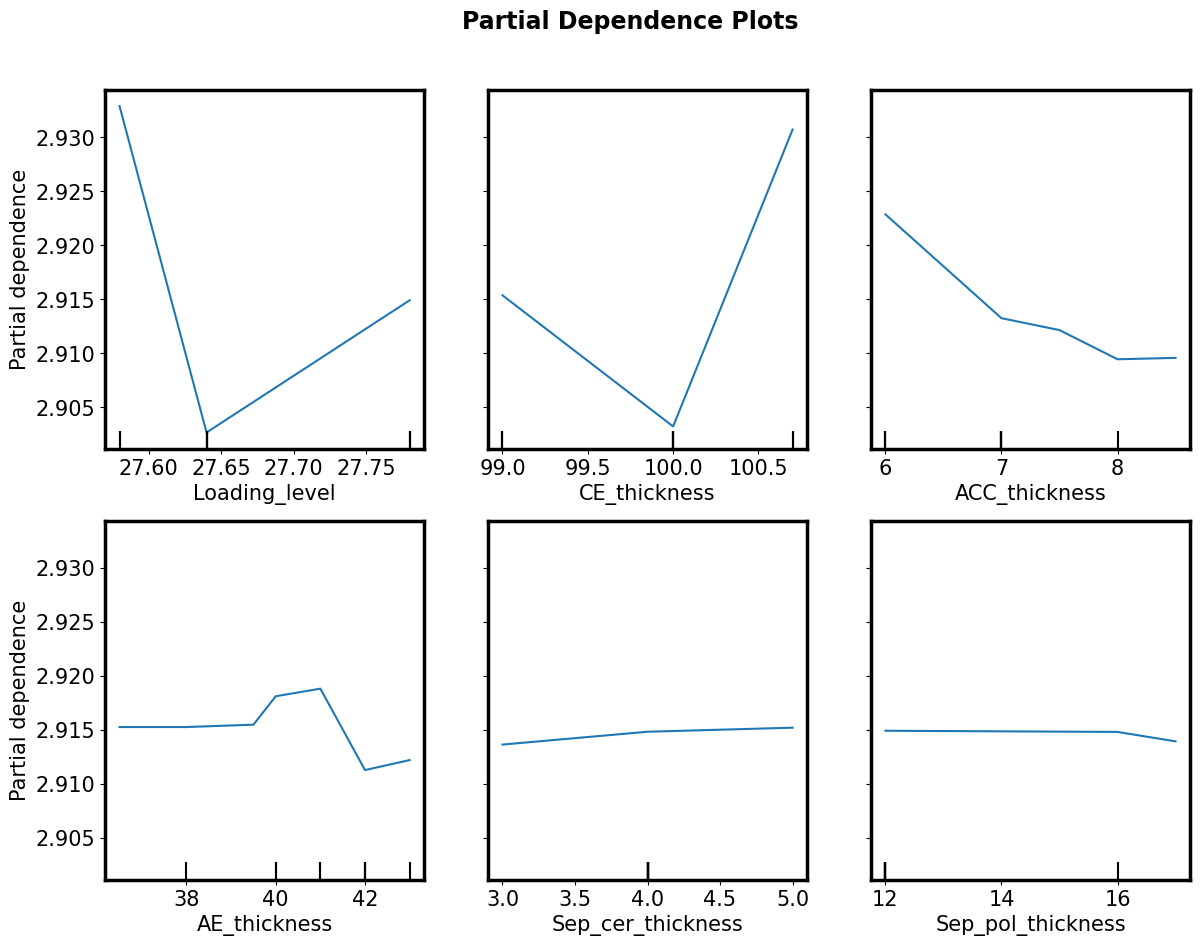

In [8]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'MDI_Importance': rf.feature_importances_,
    'Permutation_Importance': permutation_importance(rf, X, y, n_repeats=30, random_state=42).importances_mean,
    'Permutation_Importance_std': permutation_importance(rf, X, y, n_repeats=30, random_state=42).importances_std
}).sort_values(by='Permutation_Importance', ascending=False)


title_fontsize = 17
label_fontsize = 15
tick_fontsize = 15
line_width = 2.5
spine_line_width = 2.5


fig, ax = plt.subplots(figsize=(14, 10))
features_to_plot = importance_df['Feature'].tolist()
pdp = PartialDependenceDisplay.from_estimator(rf, X, features=features_to_plot, ax=ax, grid_resolution=50)

plt.suptitle('Partial Dependence Plots', fontsize=title_fontsize, fontweight='bold')
plt.subplots_adjust(top=0.9)

for ax in pdp.axes_.flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(spine_line_width)

for ax in pdp.axes_.flatten():
    ax.title.set_size(title_fontsize)
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)

plt.savefig('partial_dependence_plots.png', dpi=300)
plt.show()


3. Feature Selector 2: Mean Decrease in Impurity and Permutation Importance 

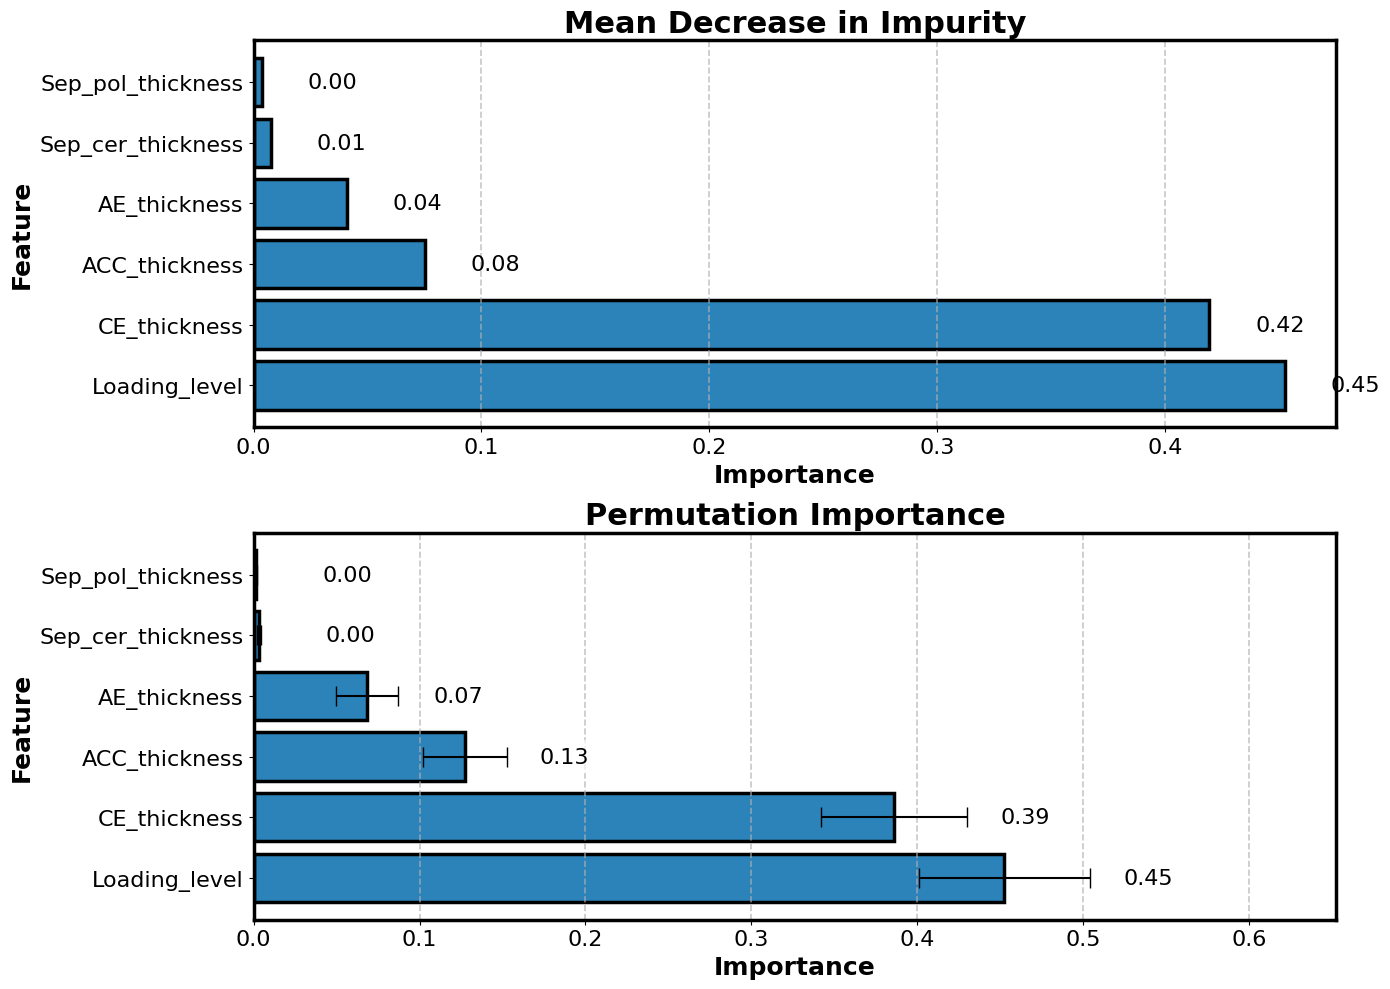

In [9]:
mdi_importances = rf.feature_importances_
perm_importance = permutation_importance(rf, X, y, n_repeats=30, random_state=42)
perm_importances = perm_importance.importances_mean
perm_importances_std = perm_importance.importances_std

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'MDI_Importance': mdi_importances,
    'Permutation_Importance': perm_importances,
    'Permutation_Importance_std': perm_importances_std
}).sort_values(by='Permutation_Importance', ascending=False)


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))


bar_color = '#2b83ba' 
edge_color = 'black'
title_fontsize = 22
label_fontsize = 18
tick_fontsize = 16
annotation_fontsize = 16
line_width = 2.5
spine_line_width = 2.5
error_bar_capsize = 7

axes[0].barh(importance_df['Feature'], importance_df['MDI_Importance'], color=bar_color, edgecolor=edge_color, linewidth=line_width)
axes[0].set_title('Mean Decrease in Impurity', fontsize=title_fontsize, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=label_fontsize, fontweight='bold')
axes[0].set_ylabel('Feature', fontsize=label_fontsize, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[0].grid(axis='x', linestyle='--', linewidth=1.2, alpha=0.7)

axes[1].barh(importance_df['Feature'], importance_df['Permutation_Importance'], xerr=importance_df['Permutation_Importance_std'], color=bar_color, edgecolor=edge_color, linewidth=line_width, capsize=error_bar_capsize)
axes[1].set_title('Permutation Importance', fontsize=title_fontsize, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=label_fontsize, fontweight='bold')
axes[1].set_ylabel('Feature', fontsize=label_fontsize, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axes[1].grid(axis='x', linestyle='--', linewidth=1.2, alpha=0.7)

for index, (value, std) in enumerate(zip(importance_df['Permutation_Importance'], importance_df['Permutation_Importance_std'])):
    offset = max(std, 0.02)
    text_x = value + offset + 0.02  
    text_y = index
    text_color = 'black'
    bbox_props = {'facecolor': 'white', 'edgecolor': 'none', 'alpha': 0.7, 'boxstyle': "round,pad=0.3"}
    axes[1].annotate(f'{value:.2f}', xy=(value, index), xytext=(text_x, text_y), textcoords="data",
                     va='center', ha='left', color=text_color, bbox=bbox_props, fontsize=annotation_fontsize)

for i in axes[0].patches:
    width = i.get_width()
    axes[0].text(width + 0.02, i.get_y() + i.get_height()/2, f'{width:.2f}', ha='left', va='center', fontsize=annotation_fontsize, color='black')

axes[1].set_xlim(0, max(importance_df['Permutation_Importance']) + 0.2)

for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(spine_line_width)

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300)
plt.show()

4. Feature Selector 3: LIME

c:\Users\Seongwoo Cho\anaconda3\envs\Bayes_opt\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.9104392880746808
Prediction_local [2.9230441]
Right: 2.923924901369325


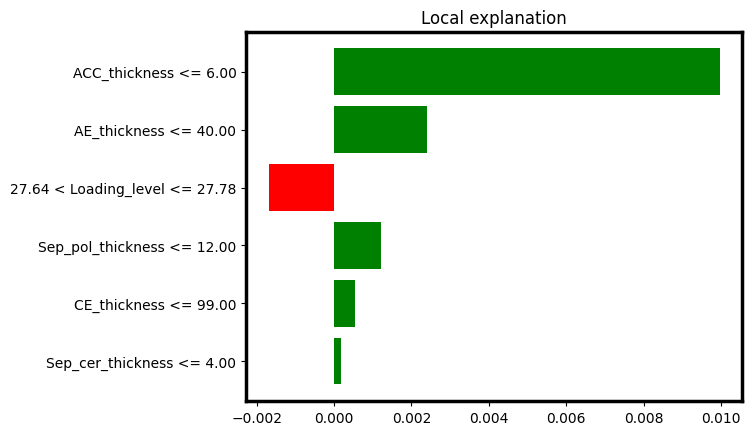

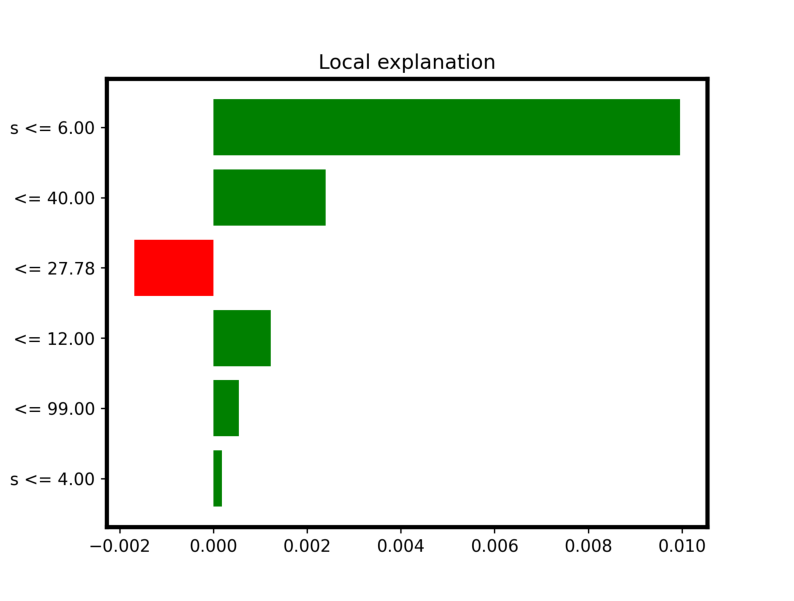

In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns, class_names=['1_discharge_capacity'], verbose=True, mode='regression')
i = 3  # Index of the instance to explain
exp = explainer.explain_instance(X.values[i], rf.predict, num_features=len(X.columns))

fig = exp.as_pyplot_figure()
ax = fig.gca()

for spine in ax.spines.values():
    spine.set_linewidth(spine_line_width)

fig.savefig('lime_explanation.png', dpi=300)

img = plt.imread('lime_explanation.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


Inspecting the minium and maxium values of each features

In [11]:
max_values = X.max()
min_values = X.min()


print("Maximum values for each column:")
print(max_values)
print("\nMinimum values for each column:")
print(min_values)


Maximum values for each column:
CE_thickness         100.70
Loading_level         27.78
AE_thickness          43.00
ACC_thickness          8.50
Sep_pol_thickness     17.00
Sep_cer_thickness      5.00
dtype: float64

Minimum values for each column:
CE_thickness         99.00
Loading_level        27.58
AE_thickness         36.50
ACC_thickness         6.00
Sep_pol_thickness    12.00
Sep_cer_thickness     3.00
dtype: float64


In [12]:
y.max()

first_dischar_capacity    2.97
dtype: float64

Determining the input variable (X) and target (y) to optimize 

In [13]:
X = data[['CE_thickness', 'Loading_level',
          'AE_thickness', 'ACC_thickness']]
y = data['first_dischar_capacity']

Determining the bounds of for each input variables by lowering the lower bounds than the minimum values and enlarging the upper bound than the maximum values 

In [14]:
fixed_bounds = {
    'CE_thickness': (98, 101.70),
    'Loading_level': (27.08, 28.28),
    'AE_thickness': (34.50, 45),
    'ACC_thickness': (4.50, 10),
}


bounds = [fixed_bounds[column] for column in X.columns]

if bounds:
    bounds_lower = [bound[0] for bound in bounds]
    bounds_upper = [bound[1] for bound in bounds]

    bounds_tensor = torch.tensor([bounds_lower, bounds_upper], dtype=torch.double).to(device)
else:
    raise ValueError("Bounds list is empty. Please check the input data.")

print("Bounds List:")
print(bounds)
print("Bounds Tensor:")
print(bounds_tensor)

Bounds List:
[(98, 101.7), (27.08, 28.28), (34.5, 45), (4.5, 10)]
Bounds Tensor:
tensor([[ 98.0000,  27.0800,  34.5000,   4.5000],
        [101.7000,  28.2800,  45.0000,  10.0000]], device='cuda:0',
       dtype=torch.float64)


Processing the data for migrating to tensor and also standardizing the input variable data and target data

In [15]:
X = X.values.astype('float64')
y = data['first_dischar_capacity'].values.astype('float64')
x_train_tensor = torch.tensor(X, dtype=torch.double)
y_train_tensor = torch.tensor(y, dtype=torch.double).squeeze(-1)

train_x = x_train_tensor.to(device)
train_y = y_train_tensor.to(device)

scaler_x = StandardScaler()
scaler_y = StandardScaler()
train_x_normalized = scaler_x.fit_transform(train_x.cpu().numpy())
train_y_normalized = scaler_y.fit_transform(train_y.cpu().numpy().reshape(-1, 1)).squeeze()

train_x_normalized = torch.tensor(train_x_normalized, dtype=torch.double).to(device)
train_y_normalized = torch.tensor(train_y_normalized, dtype=torch.double).to(device)

In [16]:
train_x_normalized

tensor([[-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281, -0.4925, -1.1472],
        [-1.2619,  1.3281,  0.6242,  0.1903],
        [-1.2619,  1.3281,  0.6242,  0.1903],
        [-1.2619,  1.3281,  0.6242

In [17]:
train_y_normalized

tensor([ 0.9019,  1.2569,  0.5470,  0.5470,  0.5470,  0.5470,  0.5470,  0.1920,
         0.5470,  0.9019,  0.5470, -0.1629,  0.5470,  0.1920, -0.5179, -0.1629,
        -0.1629, -0.5179, -0.1629, -0.1629, -0.1629, -0.1629, -0.1629, -0.1629,
        -0.1629, -0.1629, -0.1629, -0.1629, -0.1629, -0.1629, -0.1629, -0.1629,
        -0.5179, -0.1629, -0.1629, -0.8728, -1.2278, -0.1629, -0.1629,  0.1920,
         0.1920,  0.1920,  0.1920,  0.1920, -1.5827, -1.2278, -2.6475, -1.2278,
        -1.2278, -1.2278, -1.2278, -1.2278, -1.2278, -1.2278, -1.2278, -0.5179,
        -0.5179, -0.5179, -0.5179, -0.1629, -1.5827, -1.2278, -1.2278, -1.2278,
        -1.2278, -0.8728, -0.8728, -0.8728, -0.8728, -0.8728, -1.2278, -1.2278,
        -0.8728, -0.8728, -0.8728, -0.8728, -1.9377, -0.8728, -0.8728, -0.5179,
        -0.5179, -0.1629, -0.5179, -0.5179, -0.5179,  0.1920,  0.1920, -0.1629,
        -0.5179, -0.5179, -0.1629, -0.5179, -0.5179,  1.2569,  0.5470,  1.2569,
         0.9019,  0.9019,  1.6118,  1.61

In [18]:
acquisition_types = ['PI', 'EI', 'UCB']
results = {}
for acq_type in acquisition_types:
    results[acq_type] = bayesian_optimization(train_x_normalized, train_y_normalized, bounds_tensor, device, acquisition_type=acq_type, num_queries=1000)

100%|██████████| 500/500 [00:03<00:00, 145.67it/s]
c:\Users\Seongwoo Cho\anaconda3\envs\Bayes_opt\lib\site-packages\botorch\optim\optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 500/500 [00:03<00:00, 141.24it/s]
c:\Users\Seongwoo Cho\anaconda3\envs\Bayes_opt\lib\site-packages\botorch\optim\optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.m

In [19]:
for idx, acq_type in enumerate(acquisition_types):
    best_new_x, means, losses, firsts, seconds, biases, acquisition_values, new_x, best_idx, best_values, cumulative_regret, exploration_exploitation, model_uncertainties = results[acq_type]
    print(f"Best new X for {acq_type}: {best_new_x}")

Best new X for PI: tensor([[101.5400,  27.3818,  36.3493,   7.3169]], device='cuda:0',
       dtype=torch.float64)
Best new X for EI: tensor([[101.7000,  28.2800,  45.0000,   4.5000]], device='cuda:0',
       dtype=torch.float64)
Best new X for UCB: tensor([[101.7000,  28.2800,  34.5000,  10.0000]], device='cuda:0',
       dtype=torch.float64)


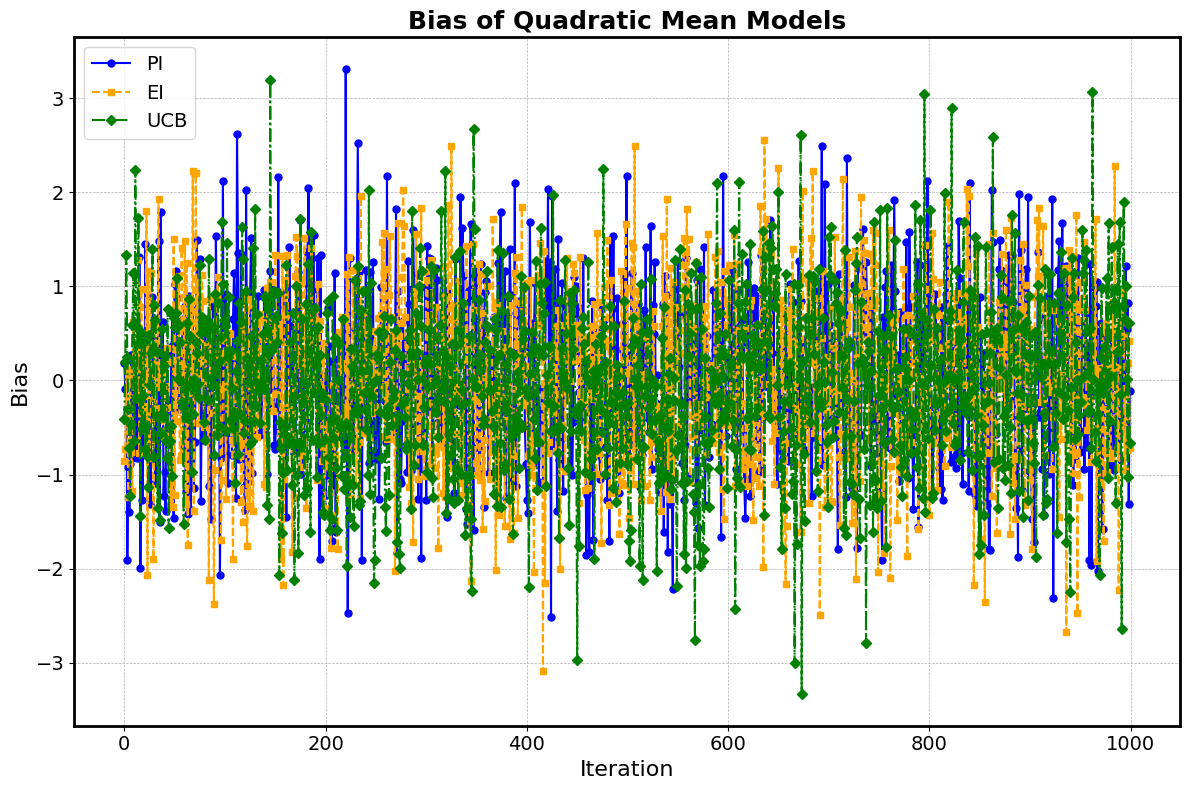

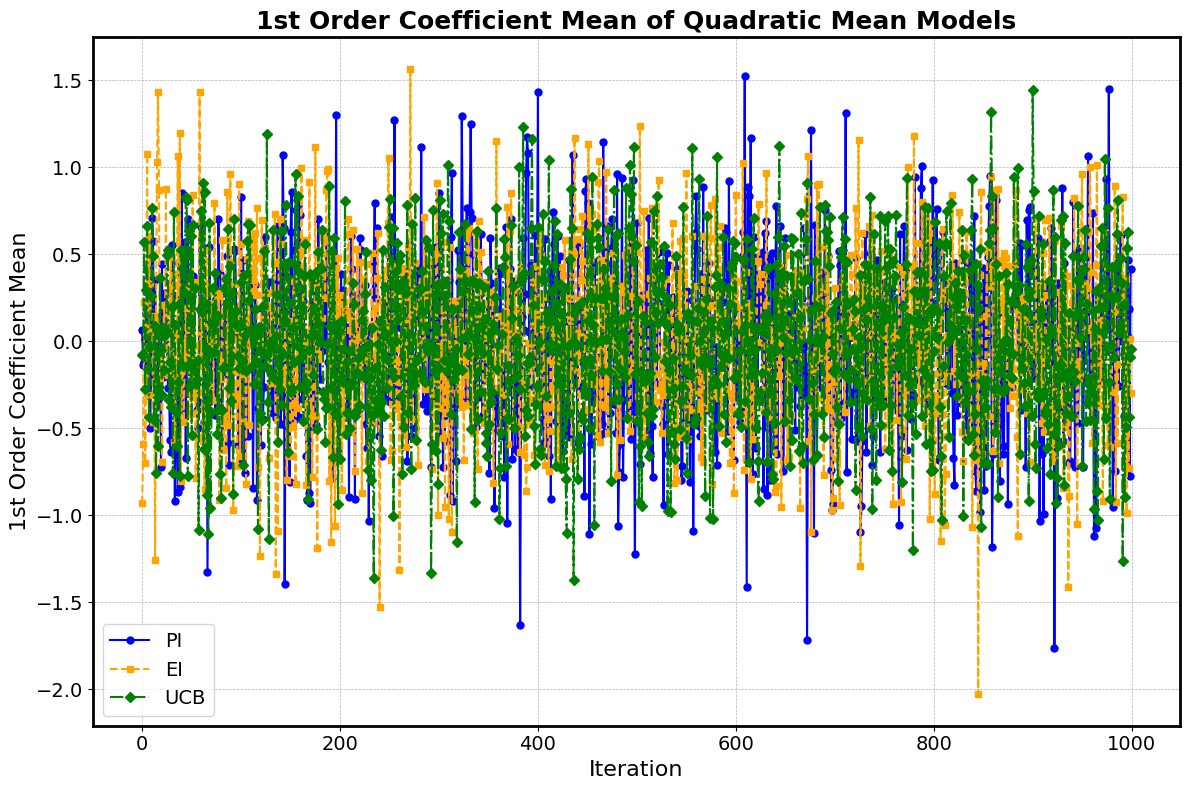

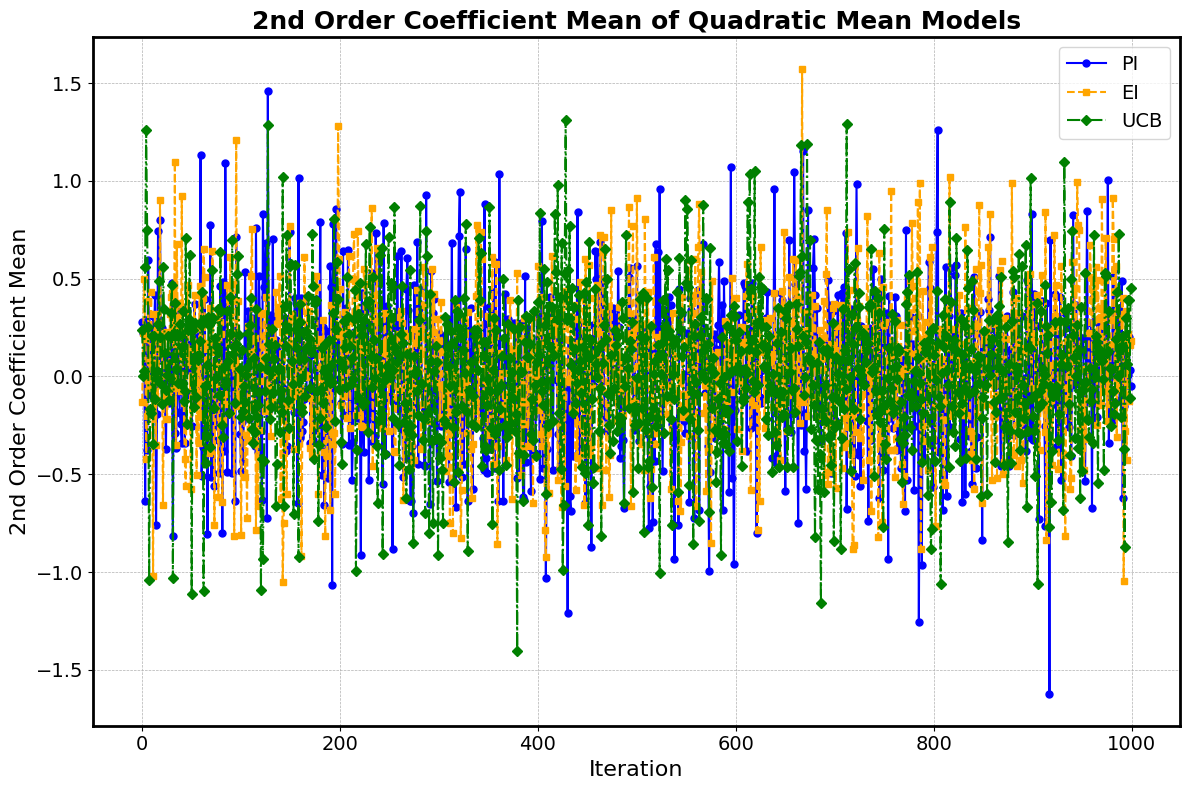

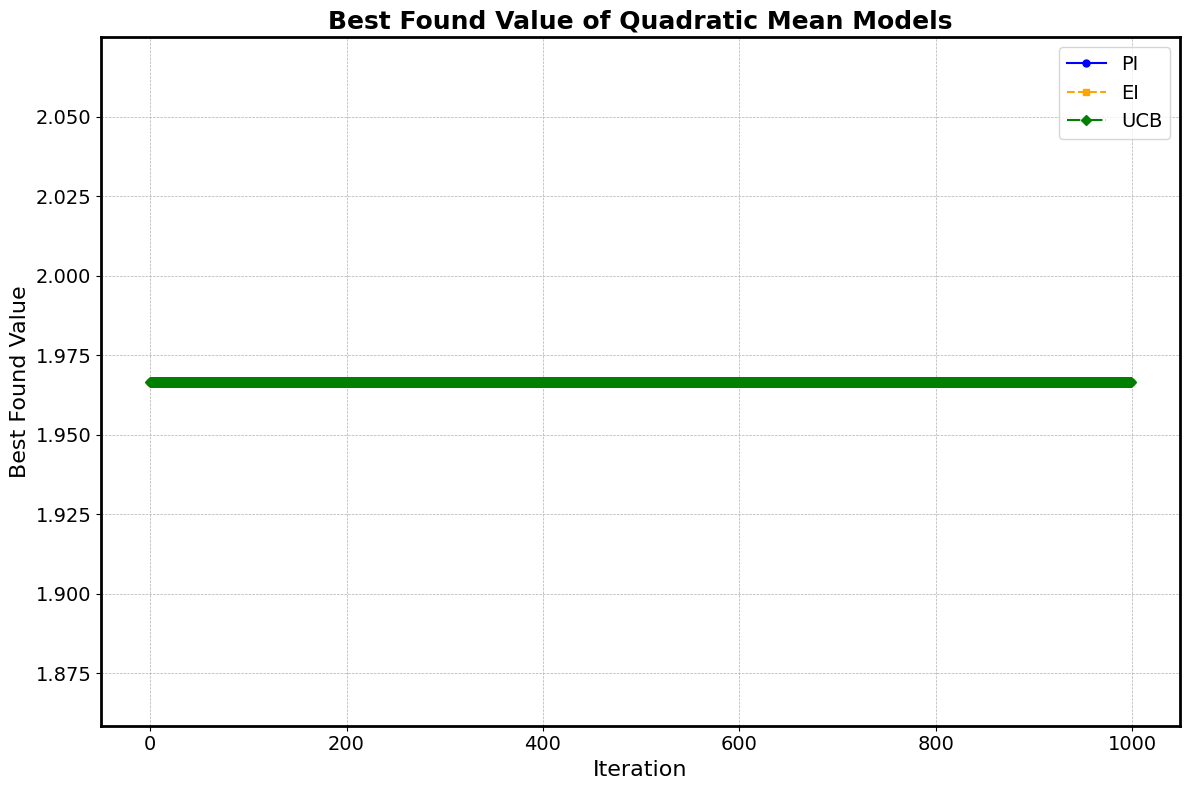

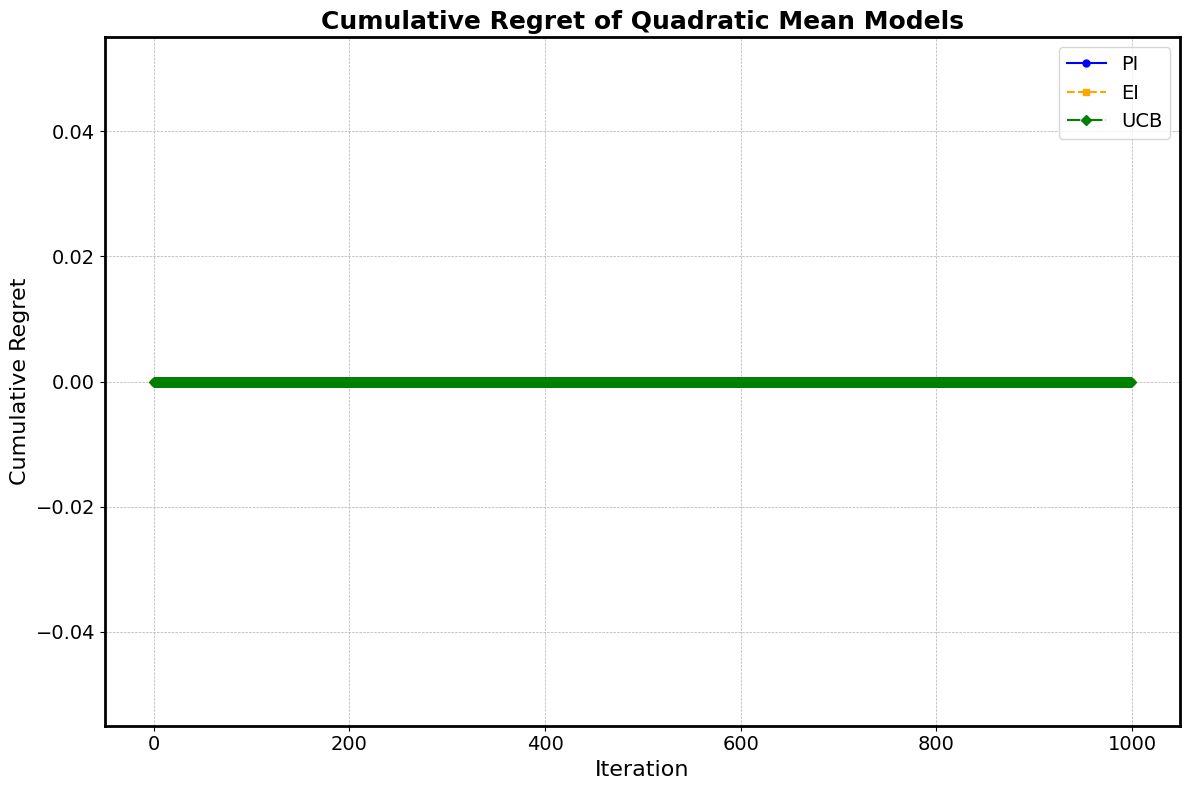

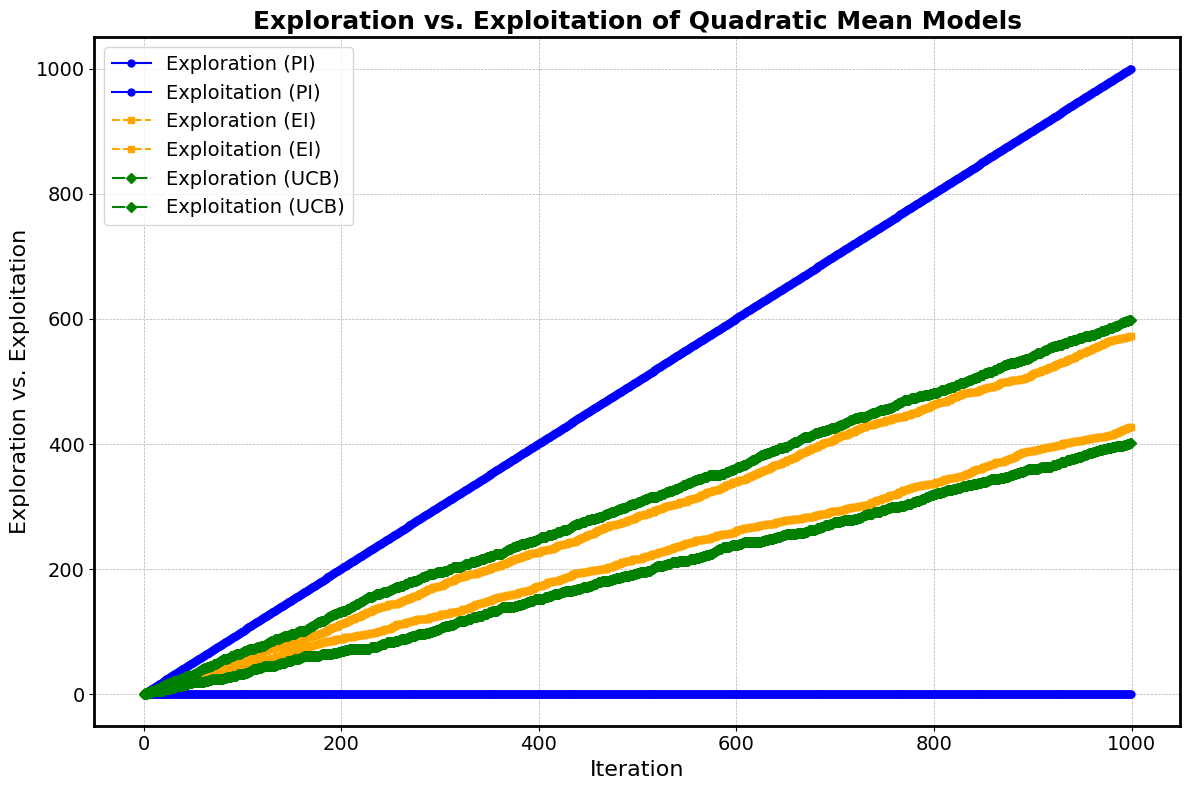

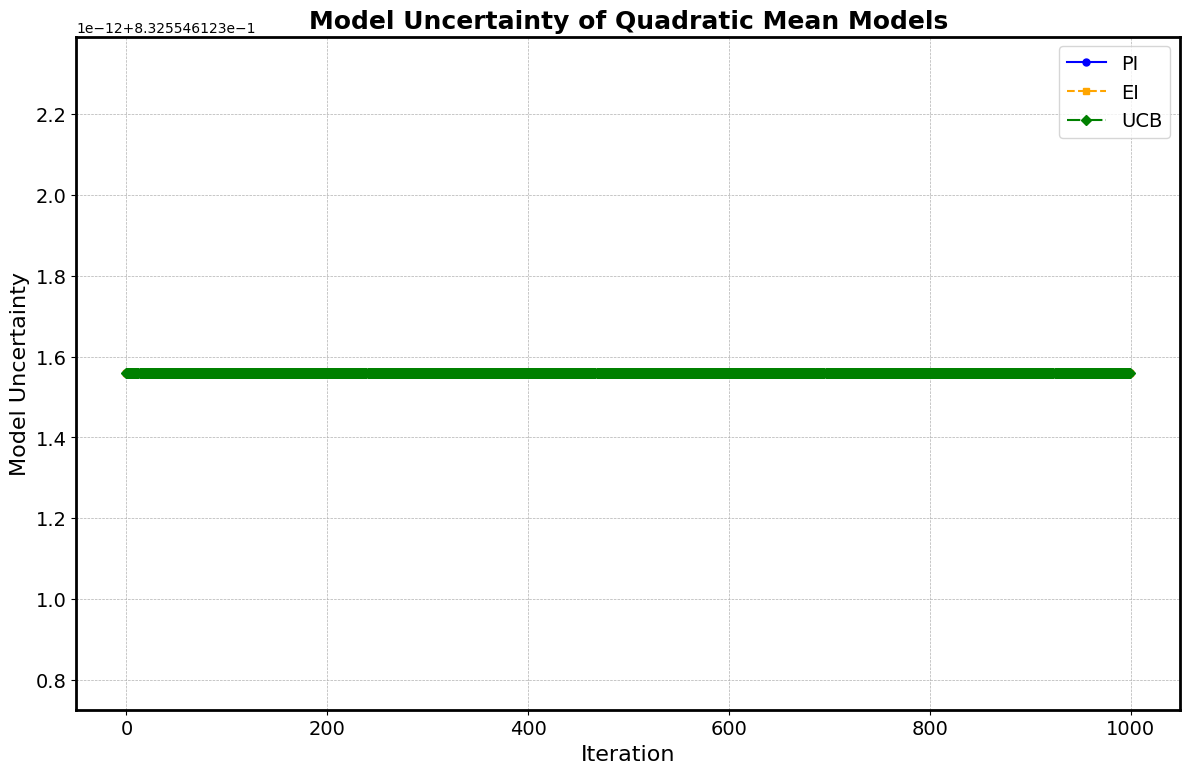

C:\Users\Seongwoo Cho\AppData\Local\Temp\ipykernel_8636\3255385280.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


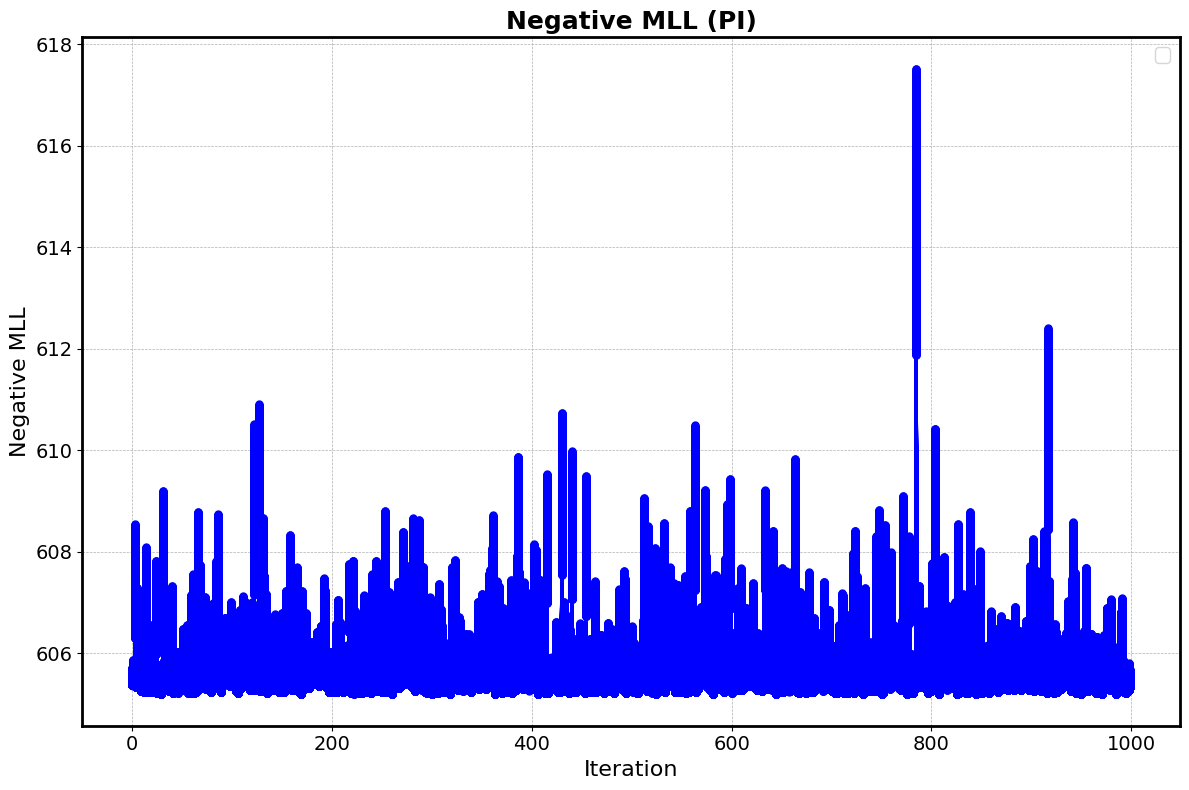

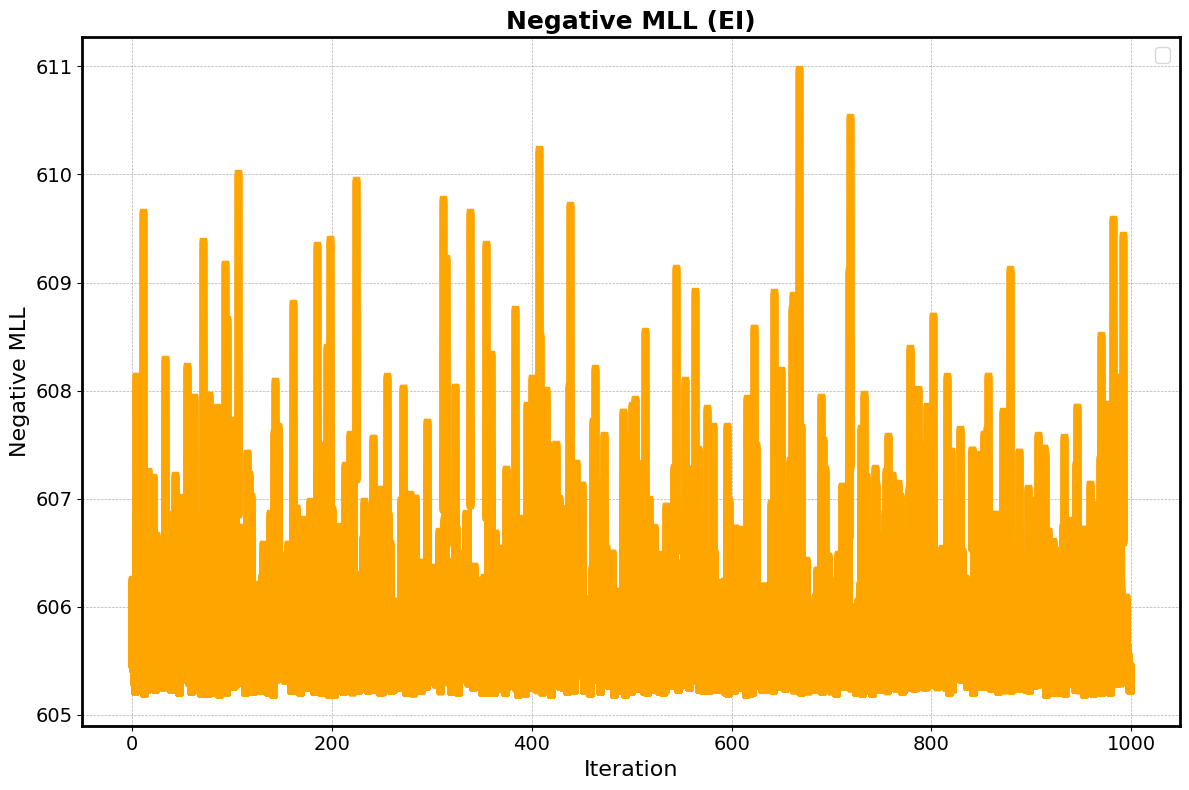

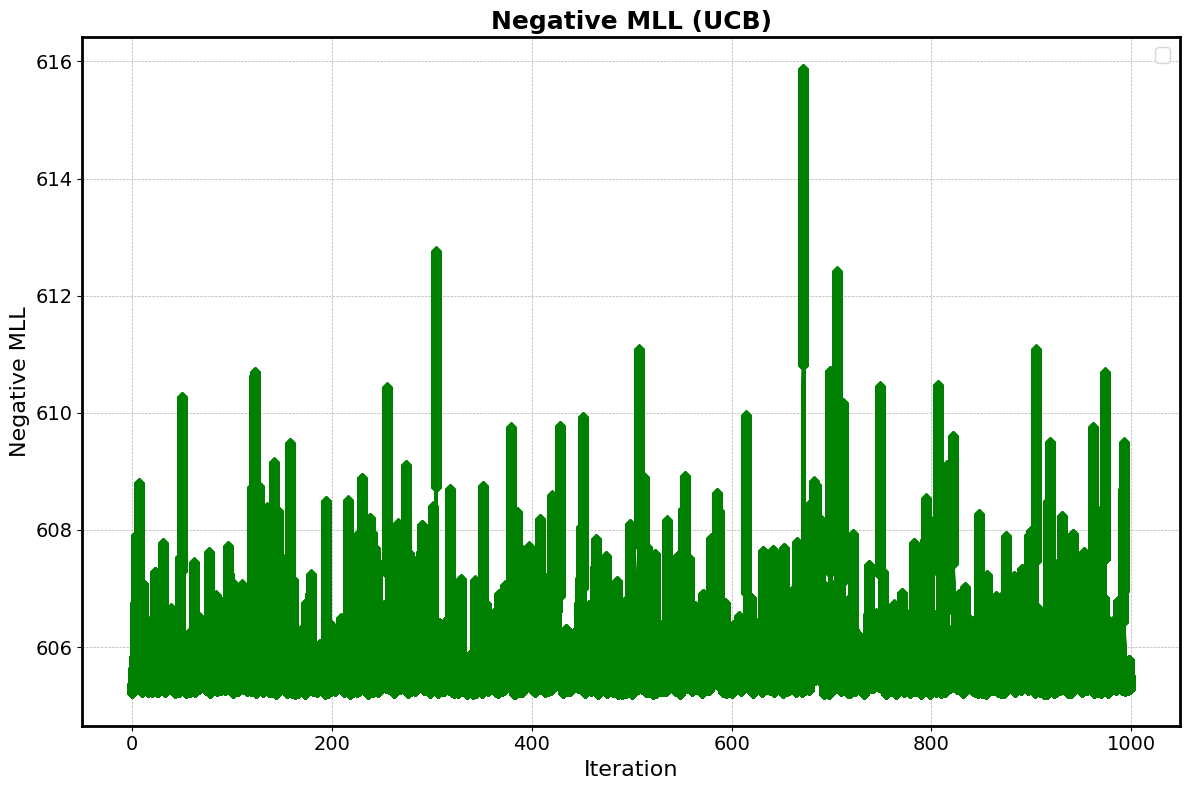

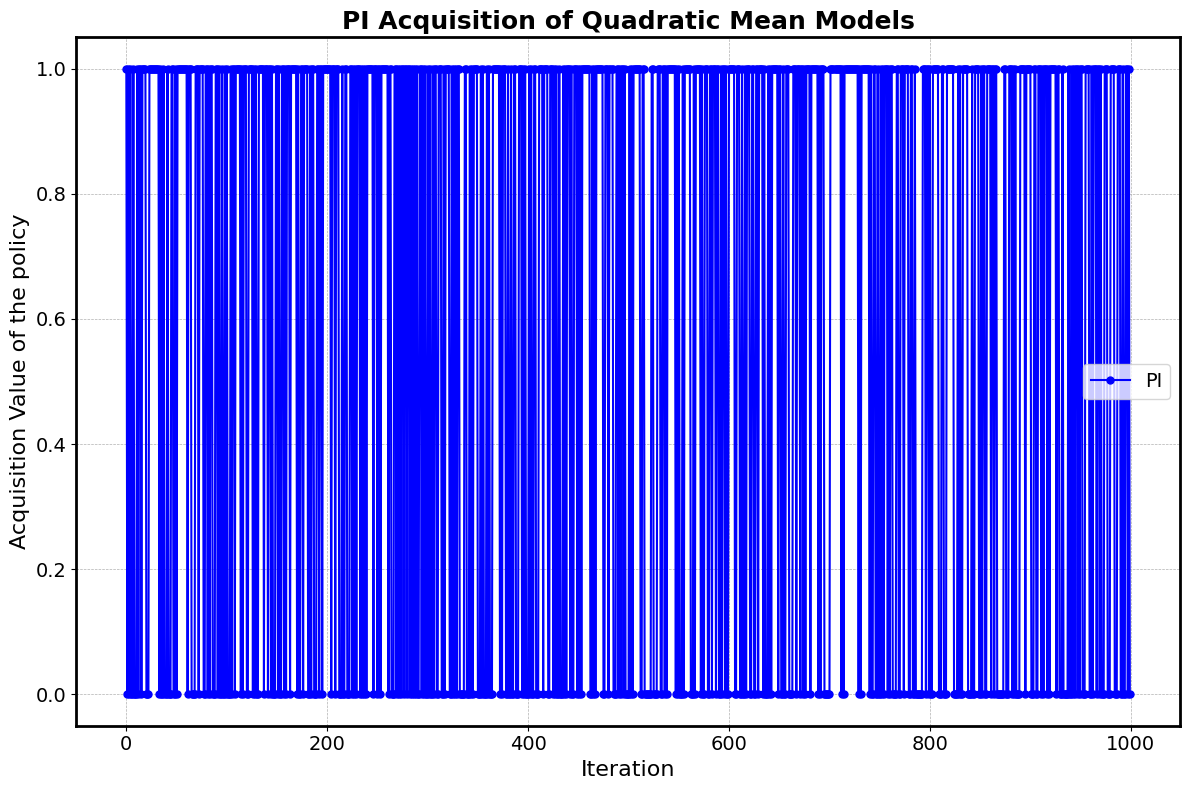

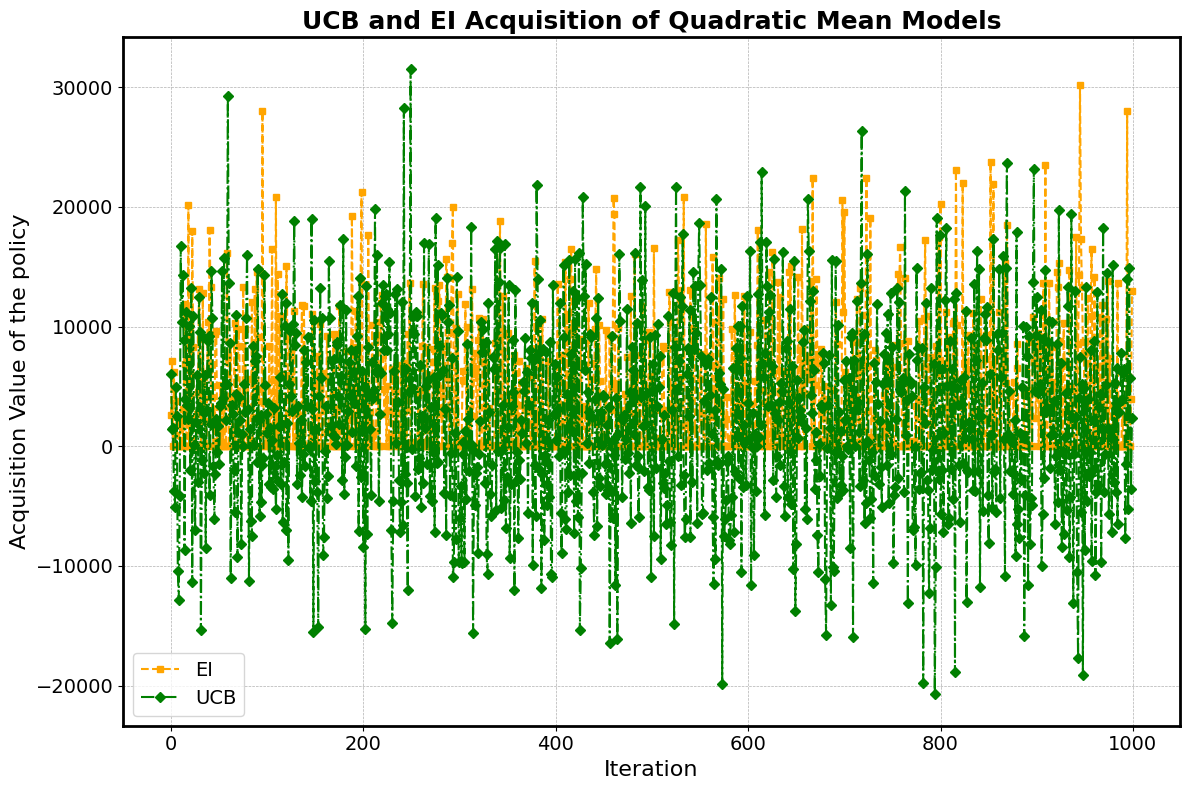

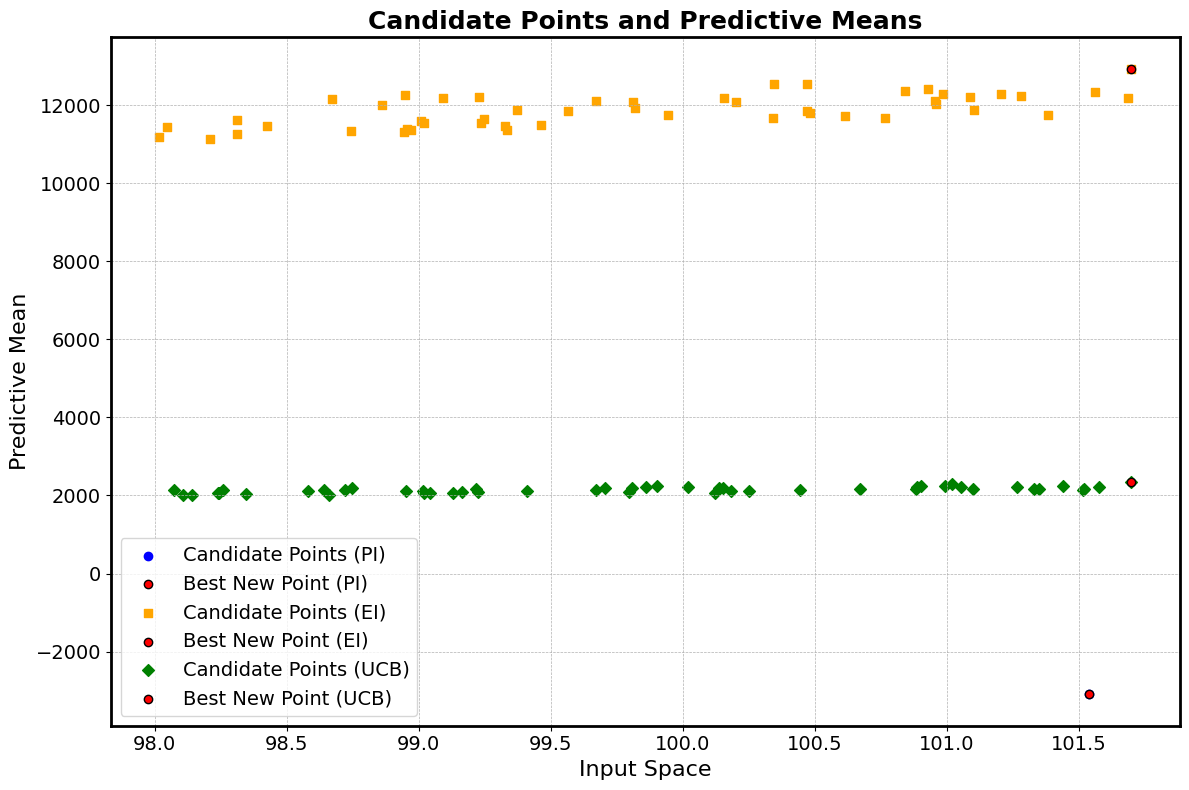

In [20]:
acquisition_types = ['PI', 'EI', 'UCB']
colors = {'PI': 'blue', 'EI': 'orange', 'UCB': 'green'}
linestyles = {'PI': '-', 'EI': '--', 'UCB': '-.'}
markers = {'PI': 'o', 'EI': 's', 'UCB': 'D'}

def enhance_plot(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

metrics = ['Bias', '1st Order Coefficient Mean', '2nd Order Coefficient Mean', 'Best Found Value', 'Cumulative Regret', 'Exploration vs. Exploitation', 'Model Uncertainty']

for metric_idx, metric in enumerate(metrics):
    plt.figure(figsize=(12, 8))
    ax = plt.gca() 
    for acq_type in acquisition_types:
        best_new_x, means, losses, firsts, seconds, biases, acquisition_values, new_x, best_idx, best_values, cumulative_regret, exploration_exploitation, model_uncertainties = results[acq_type]
        if metric == 'Bias':
            plt.plot(biases, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
        elif metric == '1st Order Coefficient Mean':
            plt.plot(firsts, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
        elif metric == '2nd Order Coefficient Mean':
            plt.plot(seconds, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
        elif metric == 'Best Found Value':
            plt.plot(best_values, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
        elif metric == 'Cumulative Regret':
            plt.plot(cumulative_regret, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
        elif metric == 'Exploration vs. Exploitation':
            exploration_counts, exploitation_counts = zip(*exploration_exploitation)
            plt.plot(exploration_counts, label=f'Exploration ({acq_type})', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
            plt.plot(exploitation_counts, label=f'Exploitation ({acq_type})', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
        elif metric == 'Model Uncertainty':
            plt.plot(model_uncertainties, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.title(f'{metric} of Quadratic Mean Models', fontsize=18, fontweight='bold')
    plt.legend(fontsize=14)
    enhance_plot(ax)
    plt.tight_layout()
    plt.show()

for idx, acq_type in enumerate(acquisition_types):
    plt.figure(figsize=(12, 8))
    ax = plt.gca()  # Get current axis
    best_new_x, means, losses, firsts, seconds, biases, acquisition_values, new_x, best_idx, best_values, cumulative_regret, exploration_exploitation, model_uncertainties = results[acq_type]
    plt.plot(losses, color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Negative MLL", fontsize=16)
    plt.title(f'Negative MLL ({acq_type})', fontsize=18, fontweight='bold')
    plt.legend(fontsize=14)
    enhance_plot(ax)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 8))
ax = plt.gca() 
for acq_type in acquisition_types:
    if acq_type == 'PI': 
        _, _, _, _, _, _, acquisition_values, _, _, _, _, _, _ = results[acq_type]
        plt.plot(acquisition_values, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Acquisition Value of the policy', fontsize=16)
plt.title('PI Acquisition of Quadratic Mean Models', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
enhance_plot(ax)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
ax = plt.gca() 
for acq_type in acquisition_types:
    if acq_type in ['UCB', 'EI']:
        _, _, _, _, _, _, acquisition_values, _, _, _, _, _, _ = results[acq_type]
        plt.plot(acquisition_values, label=f'{acq_type}', color=colors[acq_type], linestyle=linestyles[acq_type], marker=markers[acq_type], markersize=5)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Acquisition Value of the policy', fontsize=16)
plt.title('UCB and EI Acquisition of Quadratic Mean Models', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
enhance_plot(ax)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
ax = plt.gca() 
for acq_type in acquisition_types:
    best_new_x, means, _, _, _, _, _, new_x, best_idx, _, _, _, _ = results[acq_type]
    new_x = new_x.cpu().numpy()
    means = means.cpu().numpy()

    if new_x.ndim > 2:
        new_x = new_x.squeeze()
    if new_x.ndim > 1:
        new_x = new_x[:, 0]

    plt.scatter(new_x, means, label=f'Candidate Points ({acq_type})', color=colors[acq_type], marker=markers[acq_type])
    plt.scatter(new_x[best_idx], means[best_idx], label=f'Best New Point ({acq_type})', color='red', edgecolor='black', zorder=5)

plt.xlabel('Input Space', fontsize=16)
plt.ylabel('Predictive Mean', fontsize=16)
plt.title('Candidate Points and Predictive Means', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
enhance_plot(ax)
plt.tight_layout()
plt.show()


Best new X for PI: [[101.54001725  27.38183885  36.34931271   7.31691378]]
Best new X for EI: [[101.7   28.28  45.     4.5 ]]
Best new X for UCB: [[101.7   28.28  34.5   10.  ]]


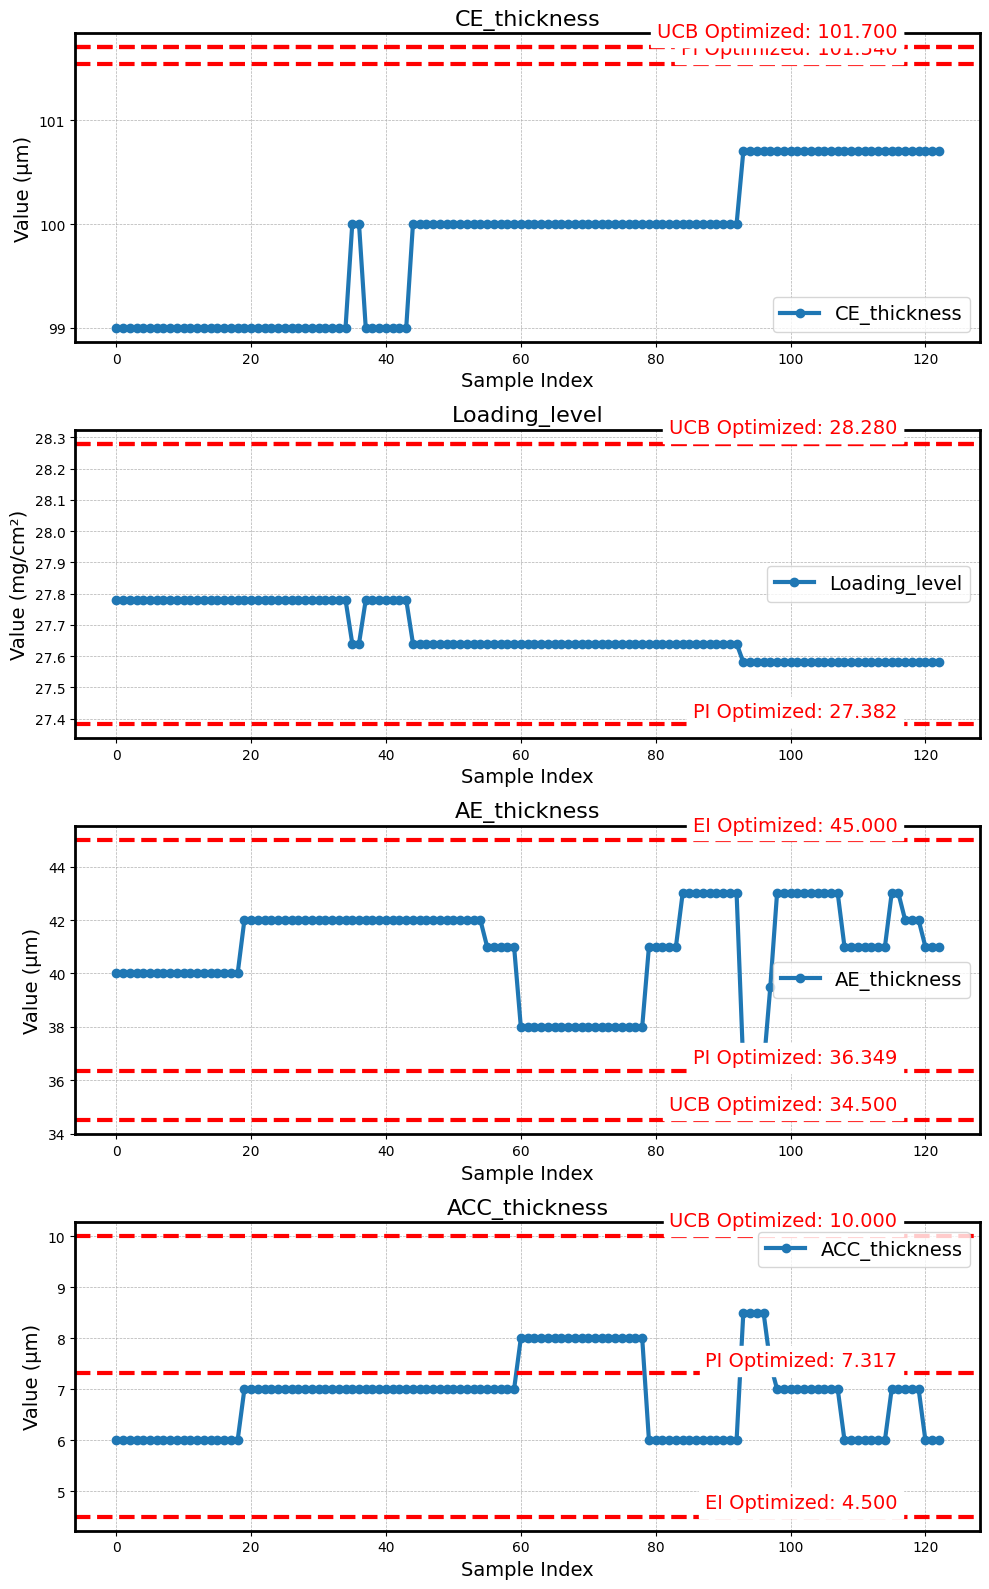

In [21]:
# Extract and print best new X values for each acquisition type
acquisition_types = ['PI', 'EI', 'UCB']
best_new_x_values = {acq_type: results[acq_type][0].cpu().numpy() for acq_type in acquisition_types}
for acq_type, best_x in best_new_x_values.items():
    print(f"Best new X for {acq_type}: {best_x}")

# Optimized values for each column (example with placeholders)
optimized_values = {
    'PI': best_new_x_values['PI'][0],  # Select appropriate index if best_new_x_values contains multiple values
    'EI': best_new_x_values['EI'][0],
    'UCB': best_new_x_values['UCB'][0]
}

# Units for each column (example)
units = {
    'CE_thickness': 'μm',
    'Loading_level': 'mg/cm²',
    'AE_thickness': 'μm',
    'ACC_thickness': 'μm'
}

# Assuming `columns` and `data` are defined for plotting
columns = ['CE_thickness', 'Loading_level', 'AE_thickness', 'ACC_thickness']

# Create a figure and a set of subplots for each acquisition type
fig, axs = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 16))

# Loop through the columns and plot each one
for idx, column in enumerate(columns):
    axs[idx].plot(data.index, data[column], label=column, marker='o', linestyle='-', linewidth=3)
    axs[idx].set_title(column, fontsize=16)
    axs[idx].set_xlabel('Sample Index', fontsize=14)
    axs[idx].set_ylabel(f'Value ({units[column]})', fontsize=14)  # Add units to the y-axis label
    axs[idx].legend(fontsize=14)
    axs[idx].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add horizontal lines and annotations for each acquisition type
    for acq_type in acquisition_types:
        y_value = optimized_values[acq_type][idx]
        axs[idx].axhline(y=y_value, color='red', linestyle='--', linewidth=3, label=f'{acq_type} Optimized')
        
        # Adjust annotation position to stay within the plotting area
        x_position = max(data.index) - 0.05 * len(data.index)  # Adjust x_position to prevent clipping at the edge
        y_position = y_value + (0.02 * (axs[idx].get_ylim()[1] - axs[idx].get_ylim()[0]))
        axs[idx].text(x_position, y_position, f'{acq_type} Optimized: {y_value:.3f}',
                      verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=14, backgroundcolor='white')

    # Increase spine thickness
    for spine in axs[idx].spines.values():
        spine.set_linewidth(2)

    # Set y-axis to have integer ticks only
    axs[idx].yaxis.set_major_locator(MaxNLocator(integer=True))

# Improve layout to prevent overlap
plt.tight_layout()

# Optionally, save the figure to a file
plt.savefig('plot_for_publication.pdf', format='pdf', dpi=600)

# Show the plot
plt.show()